In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import rasterio as rio
import earthpy as et
from PIL import Image
import geopandas as gpd
from rasterio.plot import show

In [22]:
# get the relative path of the current project that this notebook is in
project_path = os.path.abspath(os.path.join("readfiles.ipynb", os.pardir, os.pardir))
print("Found project in: ", project_path)
data_path = os.path.join(project_path, "Data")



def opentif(tif:str):
    pass
def openshp(shp:str):
    pass


tifs = 0
shps = 0
# Walk through the folder containing the data, and check if the files match either .tif or .shp
# If so; open that file, and print how many there were found
for root, dirs, files in os.walk(data_path):
    for name in files:
        if name.endswith(".tif"):
            print(root + "/" + name)
            #opentif(root + "/" + name)
            tifs += 1
        if name.endswith(".shp"):
            print(root + "/" + name)
            #openshp(root + "/" + name)
            shps += 1

print("Found ", tifs, " .tif files.")
print("Found ", shps, " .shps files.")        

Found project in:  /home/becode/Projects/3D-House-Project
/home/becode/Projects/3D-House-Project/Data/DHMVIIDSMRAS1m_k19/GeoTIFF/DHMVIIDSMRAS1m_k19.tif
/home/becode/Projects/3D-House-Project/Data/DHMVIIDSMRAS1m_k19/DHMVII_vdc_k19/DHMVII_vdc_k19.shp
Found  1  .tif files.
Found  1  .shps files.


In [24]:
# open the example .tif file (k19)
if os.path.exists("../Data/DHMVIIDSMRAS1m_k19/GeoTIFF/DHMVIIDSMRAS1m_k19.tif"):
    tif_file = "../Data/DHMVIIDSMRAS1m_k19/GeoTIFF/DHMVIIDSMRAS1m_k19.tif"
if os.path.exists("../Data/DHMVIIDSMRAS1m_k19/DHMVII_vdc_k19/DHMVII_vdc_k19.shp"):
    shape_file = "../Data/DHMVIIDSMRAS1m_k19/DHMVII_vdc_k19/DHMVII_vdc_k19.shp"

../Data/DHMVIIDSMRAS1m_k19/GeoTIFF/DHMVIIDSMRAS1m_k19.tif
1
17000
20000
BoundingBox(left=17000.0, bottom=178000.0, right=34000.0, top=198000.0)
EPSG:31370
(1,)


NameError: name 'plot' is not defined

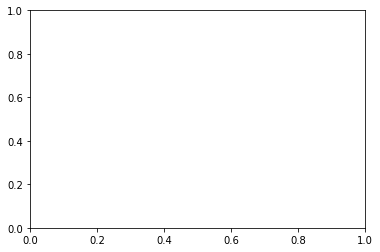

In [56]:
# Make a raster from the .tif file and get some initial information
georaster = rio.open(tif_file)
print(georaster.name)
print(georaster.count)
print(georaster.width)
print(georaster.height)
print(georaster.bounds)
print(georaster.crs)

print(georaster.indexes)
band1 = georaster.read(1)


fig = plt.figure()
ax = fig.gca()

my_area = band1[1000:1100,1000:1100]
plt.show


kerk_box = ( 
    # bottom left corner
    27280.19, 187427.64,
    # top right corner
    27333.87, 187468.36
)


In [32]:
# Open the tif and store in array
tif = Image.open(tif_file)
arr = np.array(tif)

# Get the meta data from .tif
meta = rio.open(tif_file).meta

# Save the array with the meta data as new .tif
with rio.open("./test2.tif", "w", **meta) as dst:
    dst.write(arr[:1000,:1000], indexes=1)

# Open and show new .tif
tif = Image.open("./test2.tif")
tif.show()

DecompressionBombError: Image size (340000000 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.

In [ ]:
# Center of Sint-Marinus Kerk in Leisele is at X:27326.04 Y:187447.37
# Top Left is at X:27280.19 Y:187468.36
# Bottom Right is at X:27333.87 Y:187427.64
kerk_box = ( 
    # bottom left corner
    27280.19, 187427.64,
    # top right corner
    27333.87, 187468.36
)

fig = plt.figure()
ax = fig.gca()

kerk_leisele = gpd.read_file(georaster, bbox=kerk_box)
# kerk_leisele = kerk_leisele.translate()
# kerk_leisele = kerk_leisele.to_crs(georaster.crs)
kerk_leisele.plot(ax=ax)
#surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
#                       linewidth=0, antialiased=False)